
<a id='index-0'></a>

<a id='preprocessing'></a>

# Preprocessing

Frequently the texts we have are not those we want to analyze. We may have a single file containing the collected works of an author, although we are only
interested in a single work. Or we may be given a large work broken up into
volumes (this is the case for *Les Misèrables*, as we will see later) where the
division into volumes is not important to us.

If we are interested in an author’s style, we likely want to break up a long
text (such as a book-length work) into smaller chunks, so we can get a sense of
the variability in an author’s writing. If we are comparing one group of writers
to a second group, we may wish to aggregate information about writers belonging
to the same group. This will require merging documents or other information that
were initially separate. This section illustrates these two common preprocessing
step: splitting long texts into smaller “chunks” and aggregating texts together.

Another important preprocessing step is tokenization. This is the process of
splitting a text into individual words or sequences of words (*n-grams*).
Decisions regarding tokenization will depend on the language(s) being studied
and the research question. For example, should the phrase `"her father's
arm-chair"` be tokenized as `["her", "father", "s", "arm", "chair"]` or
`["her", "father's", "arm-chair"]`. Tokenization patterns that work for one
language may not be appropriate for another (What is the appropriate
tokenization of “Qu’est-ce que c’est?”?). This section begins with a brief
discussion of tokenization before covering splitting and merging texts.

>**Note**
>
>Each tutorial is self-contained and should be read through in order.
Variables and functions introduced in one subsection will be referenced and used
in subsequent subsections. For example, the NumPy library `numpy` is
imported and then used later without being imported a second time.

## Tokenizing

There are many ways to tokenize a text. Often ambiguity is inescapable.
Consider the following lines of Charlotte Brontë’s *Villette*:

whose walls gleamed with foreign mirrors. Near the hearth
appeared a little group: a slight form sunk in a deep arm-
chair, one or two women busy about it, the iron-grey gentle-
man anxiously looking on. ...

Does the appropriate tokenization include “armchair” or “arm-chair”? While it
would be strange to see “arm-chair” in print today, the hyphenated version
predominates in *Villette* and other texts from the same period. “gentleman”,
however, seems preferable to “gentle-man,” although the [latter occurs in early
nineteenth century English-language books](http://books.google.com/ngrams/graph?content=gentle-man&year_start=1800&year_end=2000&corpus=15&smoothing=3&share=).
This is a case where a simple tokenization rule (resolve end-of-line hyphens)
will not cover all cases. For very large corpora containing a diversity of
authors, idiosyncrasies resulting from tokenization tend not to be particularly
consequential (“arm-chair” is not a high frequency word). For smaller corpora,
however, decisions regarding tokenization can make a profound difference.

Languages that do not mark word boundaries present an additional challenge.
Chinese and [Classical Greek](http://163.1.169.40/cgi-bin/library?e=q-000-00---0POxy--00-0-0--0prompt-10---4----de0--0-1l--1-en-50---20-about-aristotle--00031-001-0-0utfZz-8-00&a=d&c=POxy&cl=search&d=HASHe8016f6b58790a2918de2b)
provide two important examples. Consider the following sequence of Chinese
characters: 爱国人.  This sequence could be broken up into the following tokens:
[“爱”， 国人”] (to love one’s compatriots) or [“爱国”, “人”] (a country-loving
person).  Resolving this kind of ambiguity (when it can be resolved) is an
active topic of research. For Chinese and for other languages with this feature
there are a number of tokenization strategies in circulation.

Here are a number of examples of tokenizing functions:

In [76]:
import nltk
nltk.download('punkt')

In [3]:
# note: there are three spaces between "at" and "her" to make the example more
# realistic (texts are frequently plagued by such idiosyncrasies)
import string

text = "She looked at   her father's arm-chair."
text_fr = "Qu'est-ce que c'est?"

# tokenize on spaces
text.split(' ')
text_fr.split(' ')

# scikit-learn
# note that CountVectorizer discards "words" that contain only one character, such as "s"
# CountVectorizer also transforms all words into lowercase
from sklearn.feature_extraction.text import CountVectorizer
CountVectorizer().build_tokenizer()(text)
CountVectorizer().build_tokenizer()(text_fr)

# nltk word_tokenize uses the TreebankWordTokenizer and needs to be given
# a single sentence at a time.
from nltk.tokenize import word_tokenize
word_tokenize(text)
word_tokenize(text_fr)

# nltk PunktWordTokenizer
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
tokenizer.tokenize(text)
tokenizer.tokenize(text_fr)

# use of maketrans to tokenize on spaces, stripping punctuation
# see python documentation for string.translate
# string.punctuation is simply a list of punctuation

table = str.maketrans({ch: None for ch in string.punctuation})
[s.translate(table) for s in text.split(' ') if s != '']
[s.translate(table) for s in text_fr.split(' ') if s != '']

['Questce', 'que', 'cest']

### Stemming

Often we want to count inflected forms of a word together. This procedure is
referred to as *stemming*. Stemming a German text treats the following words as
instances of the word “Wald”: “Wald”, “Walde”, “Wälder”, “Wäldern”, “Waldes”,
and “Walds”. Analogously, in English the following words would be counted as
“forest”: “forest”, “forests”, “forested”, “forest’s”, “forests’”. As stemming
reduces the number of unique vocabulary items that need to be tracked, it speeds
up a variety of computational operations. For some kinds of analyses, such as
authorship attribution or fine-grained stylistic analyses, stemming may obscure
differences among writers. For example, one author may be distinguished by the
use of a plural form of a word.

NLTK offers stemming for a variety of languages in the [nltk.stem package](http://nltk.org/api/nltk.stem.html). The following code illustrates the use of the popular
Snowball stemmer:

In [4]:
from nltk.stem.snowball import GermanStemmer

stemmer = GermanStemmer()

# note that the stem function works one word at a time
words = ["Wald", "Walde", "Wälder", "Wäldern", "Waldes", "Walds"]

[stemmer.stem(w) for w in words]

# note that the stemming algorithm "understands" grammar to some extent and that if "Waldi" were to appear in a text, it would not be stemmed.
stemmer.stem("Waldi")

'waldi'

## Chunking

Splitting a long text into smaller samples is a common task in text analysis. As
most kinds of quantitative text analysis take as inputs an unordered list of
words, breaking a text up into smaller chunks allows one to preserve context
that would otherwise be discarded; observing two words together in
a paragraph-sized chunk of text tells us much more about the relationship
between those two words than observing two words occurring together in an
100.000 word book. Or, as we will be using a selection of tragedies as our
examples, we might consider the difference between knowing that two character
names occur in the same scene versus knowing that the two names occur in the
same play.

To demonstrate how to divide a large text into smaller chunks, we will be
working with the [corpus of French tragedies](datasets.ipynb #datasets). The following
shows the first plays in the corpus:

In [10]:
from pathlib import Path
import os

# plays are in the directory data/french-tragedy
# gather all the filenames, sorted alphabetically
jupyter_path = Path.cwd()
corpus_path = Path.joinpath(jupyter_path.resolve().parent, 'data', 'french-tragedy')
#print(corpus_path)

# look at the first few filenames
# (we are sorting because different operating systems may list files in different orders)
sorted(os.listdir(path=corpus_path))

# we will need the entire path, e.g., 'data/Crebillon_TR-V-1703-Idomenee.txt'
# rather than just 'Crebillon_TR-V-1703-Idomenee.txt' alone.
tragedy_filenames = [os.path.join(corpus_path, filename) for filename in sorted(os.listdir(corpus_path))]
tragedy_filenames_orig = []
try:
    tragedy_filenames_orig = tragedy_filenames.copy()
except:
    print("An exception occurred")

try:
    assert sorted(tragedy_filenames) == sorted(tragedy_filenames_orig)
except:
    print("An exception occurred")

### Every 1,000 words

One way to split a text is to read through it and create a chunk every *n*
words, where *n* is a number such as 500, 1,000 or 10,000. The following
function accomplishes this:

In [11]:
def split_text(filename, n_words):
    """Split a text into chunks approximately `n_words` words in length."""
    input = open(filename, 'r', encoding="UTF-8")
    words = input.read().split(' ')
    input.close()
    # in Python the above can also be accomplished with the following lines:
    #with open(filename, 'r') as input:
     #   words = input.read().split(' ')
    chunks = []
    current_chunk_words = []
    current_chunk_word_count = 0
    for word in words:
        current_chunk_words.append(word)
        current_chunk_word_count += 1
        if current_chunk_word_count == n_words:
            chunks.append(' '.join(current_chunk_words))
            # start over for the next chunk
            current_chunk_words = []
            current_chunk_word_count = 0
    # add the final chunk, likely fewer than `n_words` in length
    chunks.append(' '.join(current_chunk_words) )
    return chunks

To divide up the plays, we simply apply this function to each text in the
corpus. We do need to be careful to record the original file name and chunk
number since we will need them later. One way to keep track of these details is to
collect them in a list of Python [dictionaries](http://docs.python.org/dev/library/stdtypes.html#mapping-types-dict). There
will be one dictionary for each chunk, containing the original filename,
a number for the chunk, and the text of the chunk.

In [42]:
# for consistency across platforms (Linux, OS X, Windows) we must sort the filenames
    
import os
import numpy as np

corpus_path = Path.joinpath(jupyter_path.resolve().parent, 'data', 'french-tragedy')
sorted(os.listdir(path=corpus_path))[0:5]

tragedy_filenames.sort()

chunk_length = 1000
chunks = []
for filename in tragedy_filenames:
    chunk_counter = 0
    texts = split_text(filename, chunk_length)
    for text in texts:
        chunk = {'text': text, 'number': chunk_counter, 'filename': filename}
        chunks.append(chunk)
        chunk_counter += 1

# we started with this many files ...
len(tragedy_filenames)

# ... and now we have this many
len(chunks)

# from the triples we can create a document-term matrix
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=5, max_df=.95)
dtm = vectorizer.fit_transform([c['text'] for c in chunks])
vocab = np.array(vectorizer.get_feature_names_out())

59
2740


#### Writing chunks to a directory

These chunks may be saved in a directory for reference or for analysis in
another program (such as MALLET or R).

In [54]:
# splitting up these blocks seems to help reduce strange ipython directive
# parse failures
# make sure the directory exists
output_dir = os.path.join(jupyter_path_1.resolve().parent, '_build')

for chunk in chunks:
    basename = os.path.basename(chunk['filename'])
    fn = os.path.join(output_dir,
    "{}{:04d}".format(basename, chunk['number']))
    with open(fn, 'w') as f:
        f.write(chunk['text'])

(A stand-alone script for splitting texts is available:
<a href=split-text.py download>split-text.py</a>.)

### Every paragraph

It is possible to split a document into paragraph-length chunks. Finding the
appropriate character (sequence) that marks a paragraph boundary requires
familiarity with how paragraphs are encoded in the text file. For example, the
version of *Jane Eyre* provided in the [austen-brontë corpus](datasets.ipynb#datasets),
contains no line breaks within paragraphs inside chapters, so the paragraph
marker in this case is simply the newline. Using the `split` string method
with the newline as the argument (`split('\n')`) will break the text into
paragraphs. That is, if the text of *Jane Eyre* is contained in the variable
`text` then the following sequence will split the document into
paragraphs:

In [56]:
text = "There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.\nI was glad of it: I never liked long walks, especially on chilly afternoons: dreadful to me was the coming home in the raw twilight, with nipped fingers and toes, and a heart saddened by the chidings of Bessie, the nurse, and humbled by the consciousness of my physical inferiority to Eliza, John, and Georgiana Reed."
paragraphs = text.split('\n')
paragraphs

['There was no possibility of taking a walk that day. We had been wandering, indeed, in the leafless shrubbery an hour in the morning; but since dinner (Mrs. Reed, when there was no company, dined early) the cold winter wind had brought with it clouds so sombre, and a rain so penetrating, that further out-door exercise was now out of the question.',
 'I was glad of it: I never liked long walks, especially on chilly afternoons: dreadful to me was the coming home in the raw twilight, with nipped fingers and toes, and a heart saddened by the chidings of Bessie, the nurse, and humbled by the consciousness of my physical inferiority to Eliza, John, and Georgiana Reed.']

By contrast, in the [Project Gutenberg edition of Brontë’s novel](http://www.gutenberg.org/cache/epub/1260/pg1260.txt), paragraphs are set off
by two newlines in sequence. We still use the `split` method, but we will use
two newlines `\n\n` as our delimiter:

In [57]:
text = "There was no possibility of taking a walk that day.  We had been\nwandering, indeed, in the leafless shrubbery an hour in the morning; but\nsince dinner (Mrs. Reed, when there was no company, dined early) the cold\nwinter wind had brought with it clouds so sombre, and a rain so\npenetrating, that further out-door exercise was now out of the question.\n\nI was glad of it: I never liked long walks, especially on chilly\nafternoons: dreadful to me was the coming home in the raw twilight, with\nnipped fingers and toes, and a heart saddened by the chidings of Bessie,\nthe nurse, and humbled by the consciousness of my physical inferiority to\nEliza, John, and Georgiana Reed."
paragraphs = text.split('\n\n')
paragraphs

['There was no possibility of taking a walk that day.  We had been\nwandering, indeed, in the leafless shrubbery an hour in the morning; but\nsince dinner (Mrs. Reed, when there was no company, dined early) the cold\nwinter wind had brought with it clouds so sombre, and a rain so\npenetrating, that further out-door exercise was now out of the question.',
 'I was glad of it: I never liked long walks, especially on chilly\nafternoons: dreadful to me was the coming home in the raw twilight, with\nnipped fingers and toes, and a heart saddened by the chidings of Bessie,\nthe nurse, and humbled by the consciousness of my physical inferiority to\nEliza, John, and Georgiana Reed.']

## Grouping

When comparing groups of texts, we often want to aggregate information about the
texts that comprise each group. For instance, we may be interested in comparing
the works of one author with the works of another author. Or we may be
interested in comparing texts published before 1800 with texts published after
1800. In order to do this, we need a strategy for collecting information (often
word frequencies) associated with every text in a group.

As an illustration, consider the task of grouping word frequencies in French
tragedies by author. We have four authors (Crébillon, Corneille, Racine, and
Voltaire) and 60 texts. Typically, the first step in grouping texts together is
determining what criterion or “key” defines a group. In this case the key is the
author, which is conveniently recorded at the beginning of each filename in our
corpus. So our first step will be to associate each text (the contents of each
file) with the name of its author. As before we will use a list of dictionaries
to manage our data.

In [58]:
# in every filename the author's last name is followed by an underscore ('_'),
# for example: Voltaire_TR-V-1764-Olympie.txt

# os.path.basename(...) gets us the filename from a path, e.g.,
os.path.basename('french-tragedy/Voltaire_TR-V-1764-Olympie.txt')

# using the split method we can break up the string on the underscore ('_')
os.path.basename('french-tragedy/Voltaire_TR-V-1764-Olympie.txt').split('_')

# putting these two steps together
author = os.path.basename('french-tragedy/Voltaire_TR-V-1764-Olympie.txt').split('_')[0]
author

# and for all the authors
authors = [os.path.basename(filename).split('_')[0] for filename in tragedy_filenames]
authors

# to ignore duplicates we can transform the list into a set (which only records unique elements)
set(authors)

# as there is no guarantee about the ordering in a set (or a dictionary) we will typically
# first drop duplicates and then save our unique names as a sorted list. Because there are
# no duplicates in this list, we can be confident that the ordering is the same every time.
sorted(set(authors))

# and we have a way of finding which indexes in authors correspond to each author using array indexing
authors = np.array(authors)  # convert from a Python list to a NumPy array
first_author = sorted(set(authors))[0]
first_author
authors == first_author
np.nonzero(authors == first_author)  # if we want the actual indexes
authors[np.nonzero(authors == first_author)]

# alternatively, we can find those indexes of texts *not* written by `first_author`
authors[authors != first_author]

array(['PCorneille', 'PCorneille', 'PCorneille', 'PCorneille',
       'PCorneille', 'PCorneille', 'PCorneille', 'PCorneille',
       'PCorneille', 'PCorneille', 'PCorneille', 'PCorneille',
       'PCorneille', 'PCorneille', 'PCorneille', 'PCorneille',
       'PCorneille', 'PCorneille', 'PCorneille', 'PCorneille', 'Racine',
       'Racine', 'Racine', 'Racine', 'Racine', 'Racine', 'Racine',
       'Racine', 'Racine', 'Racine', 'Racine', 'Voltaire', 'Voltaire',
       'Voltaire', 'Voltaire', 'Voltaire', 'Voltaire', 'Voltaire',
       'Voltaire', 'Voltaire', 'Voltaire', 'Voltaire', 'Voltaire',
       'Voltaire', 'Voltaire', 'Voltaire', 'Voltaire', 'Voltaire',
       'Voltaire', 'Voltaire'], dtype='<U10')

The easiest way to group the data is to use NumPy’s array indexing. This method
is more concise than the alternatives, and it should be familiar to those
comfortable with R or Octave/Matlab. (Those for whom this method is unfamiliar
will benefit from reviewing the introductions to NumPy mentioned in
[Getting started](getting_started.ipynb#getting-started).)

In [60]:
# first get a document-term-matrix of word frequencies for our corpus
vectorizer = CountVectorizer(input='filename')
dtm = vectorizer.fit_transform(tragedy_filenames).toarray()
vocab = np.array(vectorizer.get_feature_names_out())


In [61]:
authors = np.array([os.path.basename(filename).split('_')[0] for filename in tragedy_filenames])

# allocate an empty array to store our aggregated word frequencies
authors_unique = sorted(set(authors))
dtm_authors = np.zeros((len(authors_unique), len(vocab)))
for i, author in enumerate(authors_unique):
    dtm_authors[i, :] = np.sum(dtm[authors==author, :], axis=0)

try:
    dtm_authors_method_numpy = dtm_authors.copy()
except:
    print('An exception occurred')

In [62]:
len(author)

8

In [63]:
len(dtm)

59

>**Note**
>
>Recall that gathering together the sum of the entries along columns is
performed with `np.sum(X, axis=0)` or `X.sum(axis=0)`. This is
the NumPy equivalent of R’s `apply(X, 2, sum)` (or `colSums(X)`).

Grouping data together in this manner is such a common problem in data analysis
that there are packages devoted to making the work easier. For example, if you
have the [pandas library](http://pandas.pydata.org) installed, you can
accomplish what we just did in two lines of code:

In [64]:
import pandas as pd
authors = [os.path.basename(filename).split('_')[0] for filename in tragedy_filenames]
dtm_authors = pd.DataFrame(dtm).groupby(authors).sum().values

try:
    dtm_authors_method_pandas = dtm_authors.copy()
except: 
    print("An exception occurred")
    
try:
    np.testing.assert_array_almost_equal(dtm_authors_method_pandas, dtm_authors_method_numpy)
except:
    print("An exception occurred")

A more general strategy for grouping data together makes use of the `groupby`
function in the Python standard library [itertools](http://docs.python.org/dev/library/itertools.html). This method has the
advantage of being fast and memory efficient. As a warm-up exercise, we will
group just the filenames by author using `groupby` function.

In [65]:
import itertools
import operator

texts = []
for filename in tragedy_filenames:
    author = os.path.basename(filename).split('_')[0]
    # the following are equivalent
    # {'filename': filename, 'author':author}
    # dict(filename=filename, author=author)
    # (I find the second easier to type)
    texts.append(dict(filename=filename, author=author))

# groupby requires that the list be sorted by the 'key' with which we will be doing the grouping
texts = sorted(texts, key=operator.itemgetter('author'))

# if d is a dictionary, operator.itemgetter(key)(d) does d[key]
d = {'number': 5}
d['number']
operator.itemgetter('number')(d)

5

In [66]:
grouped_data = {}
for author, grouped in itertools.groupby(texts, key=operator.itemgetter('author')):
    grouped_data[author] = ','.join(os.path.basename(t['filename']) for t in grouped)
grouped_data

{'Crebillon': 'Crebillon_TR-V-1703-Idomenee.txt,Crebillon_TR-V-1707-Atree.txt,Crebillon_TR-V-1708-Electre.txt,Crebillon_TR-V-1711-Rhadamisthe.txt,Crebillon_TR-V-1717-Semiramis.txt,Crebillon_TR-V-1726-Pyrrhus.txt,Crebillon_TR-V-1749-Catilina.txt,Crebillon_TR-V-1749-Xerces.txt,Crebillon_TR-V-1754-Triumvirat.txt',
 'PCorneille': 'PCorneille_TR-V-1639-Medee.txt,PCorneille_TR-V-1639-Nicomede.txt,PCorneille_TR-V-1641-Horace.txt,PCorneille_TR-V-1643-Cinna.txt,PCorneille_TR-V-1643-Polyeucte.txt,PCorneille_TR-V-1644-Pompee.txt,PCorneille_TR-V-1644-Rodogune.txt,PCorneille_TR-V-1645-Theodore.txt,PCorneille_TR-V-1647-Heraclius.txt,PCorneille_TR-V-1651-Andromede.txt,PCorneille_TR-V-1653-Pertharite.txt,PCorneille_TR-V-1659-Oedipe.txt,PCorneille_TR-V-1661-Toisondor.txt,PCorneille_TR-V-1662-Sertorius.txt,PCorneille_TR-V-1663-Sophonisbe.txt,PCorneille_TR-V-1665-Othon.txt,PCorneille_TR-V-1666-Agesilas.txt,PCorneille_TR-V-1668-Attila.txt,PCorneille_TR-V-1672-Pulcherie.txt,PCorneille_TR-V-1674-Surena.txt'

The preceding lines of code demonstrate how to group filenames by author. Now we
want to aggregate document-term frequencies by author. The process is similar.
We use the same strategy of creating a collection of dictionaries with the
information we want to aggregate and the key—the author’s name—that
identifies each group.

Now that we have done the work of grouping these texts together, we can examine
the relationships among the four authors using the exploratory techniques we
learned in [Working with text](working_with_text.ipynb#working-with-text).

In [67]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(dtm_authors)
mds = MDS(n_components=2, dissimilarity="precomputed")
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

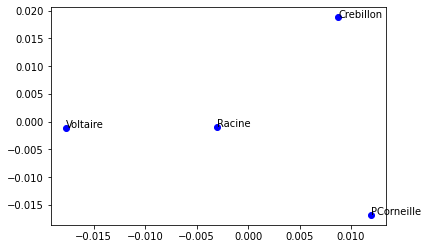

In [70]:
xs, ys = pos[:, 0], pos[:, 1]
names = sorted(set(authors))
for x, y, name in zip(xs, ys, names):
    color = matplotlib.cm.summer(names.index(name))
    plt.scatter(x, y, c='blue')
    plt.text(x, y, name)

plt.savefig('plot_preprocessing_authors_mds.png') #width=7in
plt.show()

Note that it is possible to group texts by any feature they share in common.
If, for instance, we had wanted to organize our texts into 50 year's periods
(1650-1699, 1700-1749, …) rather than by author, we would begin by extracting
the publication year from the filename.

Then we would create a list of group identifiers based on the periods that
interest us:

Finally, we would group the texts together using the same procedure as we did
with authors.

In [71]:
# extract year from filename
years = [int(os.path.basename(fn).split('-')[2]) for fn in tragedy_filenames]

try:
    years[0] == 1703
except:
    print("An exception occurred")

# using a regular expression
import re
years = [int(re.findall('[0-9]+', fn)[0]) for fn in tragedy_filenames]

try:
    years[0] == 1703
except:
    print("An exception occurred")

In [72]:
# all the texts are published between 1600 and 1800
# periods will be numbered 0, 1, 2, 3
# periods correspond to: year < 1650, 1650 <= year < 1700, ...
period_boundaries = list(range(1650, 1800 + 1, 50))
period_names = ["{}-{}".format(yr - 50, yr) for yr in period_boundaries]
periods = []

for year in years:
    for i, boundary in enumerate(period_boundaries):
        if year < boundary:
            periods.append(i)
            break

try:
    len(periods) == len(authors)
except:
    print("An exception occurred!")
    
try:
    periods[0] == 2  # Crébillon_TR-V-1703-Idomenee.txt
except:
    print("An exception occurred!")
    

# examine how many texts appear in each period
list(zip(period_names, np.bincount(periods)))


[('1600-1650', 59)]

In [74]:
vectorizer = CountVectorizer(input='filename')
dtm = vectorizer.fit_transform(tragedy_filenames).toarray()
vocab = np.array(vectorizer.get_feature_names_out())

In [75]:
periods_unique = sorted(set(periods))
dtm_periods = np.zeros((len(periods_unique), len(vocab)))
for i, period in enumerate(periods_unique):
    dtm_periods[i,:] = np.sum(dtm[np.array(periods)==period,:], axis=0)

## Exercises

1. Write a tokenizer that, as it tokenizes, also transforms uppercase words into
  lowercase words. Consider using the string method `lower`.  
1. Using your tokenizer, count the number of times `green` occurs in the
  following text sample.  

3. Personal names that occur in lowercase form in the dictionary illustrate one kind of information that is lost by ignoring case. Provide another example of useful information lost when lowercasing all words.